# Assignment 1

# Name: Thabolezwe Mabandla
# Regnum: R204443F

# 1.Loading the text data

In [154]:
def load_doc(filename):
    #open the file
    file = open(filename, 'rt',encoding='utf-8' )
    #read the text
    text = file.read()
    #close the file
    file.close()
    return text

In [155]:
# load document(book)
filename = r"C:\Users\maban\Desktop\nlpdata.txt"
text = load_doc(filename)
print(text[:200])

One morning, when Gregor Samsa woke from troubled dreams, he found
himself transformed in his bed into a horrible vermin.  He lay on
his armour-like back, and if he lifted his head a little he could
s


# 2.Preprocessing

In [156]:
#imports
import re
import string
from nltk.corpus import stopwords
stop_words = stopwords.words( 'english' )

In [157]:
def preprocess(text):
    # replace ' -- ' with a space ' '
    text = text.replace( '--' , ' ' )
    
    
    #Tokenization(Split by whitespace)
    words = text.split()

    #removing utf-8 encoding characters and other unnecessary chars
    words = [re.sub(r'[\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff\xad\x0c6§\[\]\\\£\Â\n\r]', ' ', word) for word in words]
    words = [word for word in words if word.isalpha()]

    #removing all numerical values(page numbers)
    words = [re.sub(r'[0123456789]', ' ', word) for word in words]

    #removing all punctuation
    re_punc = re.compile( ' [%s] ' % re.escape(string.punctuation))
    words = [re_punc.sub( '' , word) for word in words]

    #removing Roman numerals
    # first capitalized ones
    words = [re.sub(r'\s((I{2,}V*X*\.*)|(IV\.*)|(IX\.*)|(V\.*)|(V+I*\.*)|(X+L*V*I*]\.*))\s', ' ', word) for word in words]
    # then lowercase
    words = [re.sub(r'\s((i{2,}v*x*\.*)|(iv\.*)|(ix\.*)|(v\.*)|(v+i*\.*)|(x+l*v*i*\.*))\s', ' ', word) for word in words]


    #removing all strings of capital letters that are more than 2 characters long(Headings)
    words = [re.sub(r'[A-Z]{2,}', ' ', word) for word in words]


    #removing extra white spaces
    clean_words = [re.sub(r'\s+', ' ', word) for word in words]


    #removing stopwords and converting all words to lower case
    #words = [word.lower() for word in words]
    #clean_words = [word for word in words if word not in stop_words]
    
    
    #removing empty strings
    for word in clean_words:
        if((len(word)) == 1):
            clean_words.remove(word)
    
    return clean_words

In [158]:
corpus = preprocess(text)
corpus[300:320]

['different',
 'people',
 'all',
 'the',
 'time',
 'so',
 'that',
 'you',
 'can',
 'never',
 'get',
 'to',
 'know',
 'anyone',
 'or',
 'become',
 'friendly',
 'with',
 'It',
 'can']

# Word Embedding(GloVe)

In [159]:
# prepare tokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

t = Tokenizer(oov_token = "<OOV>",num_words=len(corpus))
t.fit_on_texts(corpus)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(corpus)

# pad documents to a max length of 100 words
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding= 'post')
#print(padded_docs[:2])
word_index = t.word_index

In [160]:
#creating embedding dictionary
import numpy as np
embeddings_index = {}
glove_file = r"C:\Users\maban\Documents\Deep Learning\glove.6B.100d.txt"
f = open(glove_file, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [161]:
# create a weight matrix for words in training docs
num_tokens = len(word_index)
embedding_dim = 100
hits = 0
misses = 0
embedding_matrix = np.zeros((num_tokens+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2243 words (7 misses)


# 3.Splitting the data

In [162]:
print( ' Total Tokens: %d ' % len(corpus))
print( ' Unique Tokens: %d ' % len(set(corpus)))


 Total Tokens: 18935 
 Unique Tokens: 2345 


In [163]:
#function to save tokens to file, one dialog per line
def save_doc(lines, filename):
    data = '\n' .join(lines)
    file = open(filename, 'w' )
    file.write(data)
    file.close()

In [164]:
#making lines of text
length = 5 + 1
sequences = list()
for i in range(length, len(corpus)):
# select sequence of tokens
    seq = corpus[i-length:i]
# convert into a line
    line = ' ' .join(seq)
# store
    sequences.append(line)
print( ' Total Sequences: %d ' % len(sequences))
# save sequences to file
out_filename = 'organized_sequences.txt'
save_doc(sequences, out_filename)

 Total Sequences: 18929 


In [165]:
sequences[0]

'One when Gregor Samsa woke from'

In [166]:
def load(filename):
    #open the file
    file = open(filename, 'rt')
    #read the text
    text = file.read()
    #close the file
    file.close()
    return text

In [167]:
# load
in_filename = 'organized_sequences.txt'
doc = load(in_filename)
lines = doc.split( '\n' )

# integer encode sequences of words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
padded_sequences = pad_sequences(sequences)

# vocabulary size
vocab_size = len(tokenizer.word_index) + 2

# Separating sequences into Input and Output(X and Y)


In [168]:
from tensorflow.keras.utils import to_categorical

# separate into input and output
sequences = np.asarray(padded_sequences)
X, y = sequences[:,:-1], sequences[:,-1]
#one hot encoding the output word
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]


In [169]:
X[:5]

array([[  57,   46,   19,  119, 1070],
       [  46,   19,  119, 1070,   25],
       [  19,  119, 1070,   25, 1071],
       [ 119, 1070,   25, 1071,    4],
       [1070,   25, 1071,    4,  205]])

In [170]:
seq_length

5

# 4.Creating a Deep LSTM

In [171]:
#Defining the Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout
from keras.layers import Embedding
from keras.initializers import Constant
from keras.utils.vis_utils import plot_model



def define_model(vocab_size, seq_length):
    model = Sequential()
    model.add(Embedding(vocab_size,100,embeddings_initializer=Constant(embedding_matrix)
                        ,input_length=seq_length,trainable=False))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation= 'relu'))
    model.add(Dense(vocab_size, activation= 'softmax' ))
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    model.summary()
    return model


In [172]:
model = define_model(vocab_size=vocab_size,seq_length=seq_length)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 5, 100)            225100    
                                                                 
 lstm_8 (LSTM)               (None, 5, 100)            80400     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 2251)              227351    
                                                                 
Total params: 623,351
Trainable params: 398,251
Non-tr

# 5.Training the model

In [173]:
#First Training
num_epochs = 100

history1 = model.fit(X,y,epochs=num_epochs,batch_size=120)

Epoch 1/100
158/158 [==============================] - 6s 22ms/step - loss: 6.1677 - accuracy: 0.0588
Epoch 2/100
158/158 [==============================] - 3s 22ms/step - loss: 5.8545 - accuracy: 0.0605
Epoch 3/100
158/158 [==============================] - 3s 22ms/step - loss: 5.8283 - accuracy: 0.0605
Epoch 4/100
158/158 [==============================] - 4s 25ms/step - loss: 5.8109 - accuracy: 0.0615
Epoch 5/100
158/158 [==============================] - 4s 23ms/step - loss: 5.7679 - accuracy: 0.0673
Epoch 6/100
158/158 [==============================] - 3s 22ms/step - loss: 5.6888 - accuracy: 0.0722
Epoch 7/100
158/158 [==============================] - 4s 22ms/step - loss: 5.6129 - accuracy: 0.0780
Epoch 8/100
158/158 [==============================] - 4s 22ms/step - loss: 5.5215 - accuracy: 0.0848
Epoch 9/100
158/158 [==============================] - 3s 22ms/step - loss: 5.4286 - accuracy: 0.0920
Epoch 10/100
158/158 [==============================] - 3s 22ms/step - loss: 5.340

158/158 [==============================] - 3s 22ms/step - loss: 1.6564 - accuracy: 0.5586
Epoch 81/100
158/158 [==============================] - 3s 22ms/step - loss: 1.6198 - accuracy: 0.5671
Epoch 82/100
158/158 [==============================] - 3s 22ms/step - loss: 1.5838 - accuracy: 0.5819
Epoch 83/100
158/158 [==============================] - 3s 22ms/step - loss: 1.5708 - accuracy: 0.5791
Epoch 84/100
158/158 [==============================] - 3s 22ms/step - loss: 1.5431 - accuracy: 0.5876
Epoch 85/100
158/158 [==============================] - 3s 22ms/step - loss: 1.5028 - accuracy: 0.5982
Epoch 86/100
158/158 [==============================] - 3s 22ms/step - loss: 1.4854 - accuracy: 0.5977
Epoch 87/100
158/158 [==============================] - 3s 22ms/step - loss: 1.4567 - accuracy: 0.6095
Epoch 88/100
158/158 [==============================] - 3s 22ms/step - loss: 1.4247 - accuracy: 0.6118
Epoch 89/100
158/158 [==============================] - 3s 22ms/step - loss: 1.3924 - 

# 6.Evaluating Model Perfomance

In [174]:
import matplotlib.pyplot as plt


def plot_graph(model,string):
    plt.plot(model.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

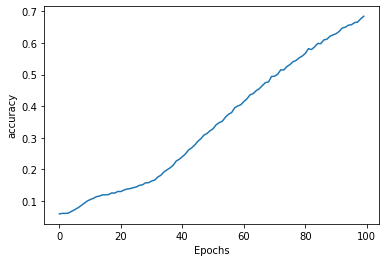

In [175]:
plot_graph(model=history1, string="accuracy")

# Optimizing the model

In [177]:
from keras.callbacks import EarlyStopping

#increasing epochs
num_epochs = 300
#to avoid overfitting
callback = EarlyStopping(monitor='loss',verbose=1,patience=15)

history2 = model.fit(X,y,epochs=num_epochs,batch_size=128,callbacks=callback)

Epoch 1/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2216 - accuracy: 0.9308
Epoch 2/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2233 - accuracy: 0.9307
Epoch 3/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2281 - accuracy: 0.9276
Epoch 4/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2249 - accuracy: 0.9301
Epoch 5/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2247 - accuracy: 0.9305
Epoch 6/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2207 - accuracy: 0.9332
Epoch 7/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2158 - accuracy: 0.9338
Epoch 8/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2136 - accuracy: 0.9332
Epoch 9/300
148/148 [==============================] - 3s 23ms/step - loss: 0.2135 - accuracy: 0.9340
Epoch 10/300
148/148 [==============================] - 3s 23ms/step - loss: 0.226

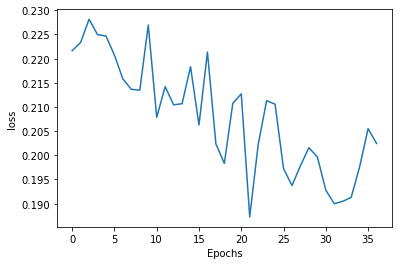

In [178]:
plot_graph(model=history2,string="loss")

# Predictions

In [254]:
# generate a sequence from a language model
def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
        result = list()
        in_text = seed_text
        # generate a fixed number of words
        for _ in range(n_words):
                # encode the text as integer
                encoded = tokenizer.texts_to_sequences([in_text])[0]
                # truncate sequences to a fixed length
                encoded = pad_sequences([encoded], maxlen=seq_length, truncating= 'pre' )
                # predict probabilities for each word
                #yhat = np.round(model.predict(encoded, verbose=0)).astype(int)
                yhat = np.argmax(model.predict(encoded, verbose=0),axis=1)
                # map predicted word index to word
                out_word = ''
                for word, index in tokenizer.word_index.items():
                        if index == yhat:
                                out_word = word
                                break
                # append to input
                in_text += ' ' + out_word
                result.append(in_text)
        return ' ' .join(result)

In [255]:
seed_text = "Alice opened the door and"
print(seed_text + ' \n ' )

Alice opened the door and 
 


In [256]:
result = generate_seq(model=model,tokenizer=tokenizer,seq_length=seq_length,seed_text=seed_text,n_words=1)

In [257]:
result

'Alice opened the door and took'

# Saving the Model and Tokenizer

In [212]:
from pickle import dump
# save the model to file
model.save( 'model.h5' )
# save the tokenizer
dump(tokenizer, open( 'tokenizer.pkl' , 'wb' ))

# 7.Hosting on Streamlit

In [218]:
!streamlit run TextGenerator.py

^C
